In [118]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [119]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [120]:
# Dataset paths
# dataset = 'TIF_DF'
dataset = 'ChildNet'
print(os.listdir(dataset))

classes = os.listdir(dataset + "/Train")
print(classes)

data_dir = dataset
train_dir = data_dir + '/Train'
test_dir = data_dir + '/Test'

['Test', 'Train']
['Angry', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sad', 'Surprised']


In [121]:
# Print class distribution
count = []
for folder in classes:
    num_images_train = len(os.listdir(train_dir + '/' + folder))
    num_images_test = len(os.listdir(test_dir + '/' + folder))
    count.append(num_images_train)
    print(f'Training Set: {folder} = {num_images_train}')
    print(f'Testing Set: {folder} = {num_images_test}')
    print("--" * 10)

Training Set: Angry = 42
Testing Set: Angry = 11
--------------------
Training Set: Disgust = 34
Testing Set: Disgust = 9
--------------------
Training Set: Fear = 26
Testing Set: Fear = 7
--------------------
Training Set: Happiness = 78
Testing Set: Happiness = 20
--------------------
Training Set: Neutral = 43
Testing Set: Neutral = 11
--------------------
Training Set: Sad = 56
Testing Set: Sad = 14
--------------------
Training Set: Surprised = 72
Testing Set: Surprised = 19
--------------------


In [122]:
# Define device (GPU or CPU)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [123]:
get_default_device()

device(type='cuda')

In [124]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [125]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [126]:
device = get_default_device()
print(f"Using device: {device}")

Using device: cuda


In [127]:
# Image transformations with data augmentation
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet stats for normalization

In [128]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomCrop(64, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

In [129]:
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

In [130]:
# Load datasets
train_ds = ImageFolder(train_dir, train_transforms)
test_ds = ImageFolder(test_dir, test_transforms)

In [131]:
train_ds

Dataset ImageFolder
    Number of datapoints: 351
    Root location: ChildNet/Train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomCrop(size=(64, 64), padding=4)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [132]:
# Create data loaders
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size * 2, num_workers=4, pin_memory=True)

In [133]:
next(iter(train_dl))

[tensor([[[[-2.0152, -2.0152, -0.6109,  ..., -2.0152, -2.0152, -2.0152],
           [-2.0152, -2.0152, -0.8164,  ..., -2.0152, -2.0152, -2.0152],
           [-2.0152, -2.0152, -0.5253,  ...,  0.2453,  0.2967,  0.2967],
           ...,
           [ 1.9235,  1.8893,  1.9235,  ...,  1.8208, -2.0152, -2.0152],
           [-2.0152, -2.0152, -2.0152,  ...,  1.8893, -2.0152, -2.0152],
           [-2.0152, -2.0152, -2.0152,  ...,  1.8379, -2.0152, -2.0152]],
 
          [[-1.9307, -1.9307, -1.4230,  ..., -1.9307, -1.9307, -1.9307],
           [-1.9307, -1.9307, -1.6506,  ..., -1.9307, -1.9307, -1.9307],
           [-1.9307, -1.9307, -1.3880,  ..., -0.7927, -0.7227, -0.7227],
           ...,
           [ 2.0784,  2.0959,  2.0784,  ...,  2.0084, -1.9307, -1.9307],
           [-1.9307, -1.9307, -1.9307,  ...,  2.0434, -1.9307, -1.9307],
           [-1.9307, -1.9307, -1.9307,  ...,  1.9734, -1.9307, -1.9307]],
 
          [[-1.6999, -1.6999, -1.3687,  ..., -1.6999, -1.6999, -1.6999],
           [-

In [134]:
# Move data to device
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [135]:
# Accuracy calculation function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [136]:
# Base model class definition
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result, train_loss=None):
        if train_loss:
            print(
                f"Epoch {epoch}: train_loss: {train_loss:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
        else:
            print(f"Epoch {epoch}: val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")


In [137]:
# ResNet50 model definition - replacing ResNet152 with ResNet50
class ResNet152Model(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained ResNet50 model
        self.network = models.resnet152(pretrained=pretrained)

        # Freeze early layers
        for param in list(self.network.parameters())[:-30]:  # Freeze all except last 30 parameter groups
            param.requires_grad = False

        # Replace last layer for our classification task
        in_features = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, xb):
        return self.network(xb)

In [138]:
# ResNet50 model definition - replacing ResNet152 with ResNet50
class ResNet50Model(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained ResNet50 model
        self.network = models.resnet50(pretrained=pretrained)

        # Freeze early layers
        for param in list(self.network.parameters())[:-30]:  # Freeze all except last 30 parameter groups
            param.requires_grad = False

        # Replace last layer for our classification task
        in_features = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, xb):
        return self.network(xb)

In [139]:
# Evaluation function
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [140]:
# Get learning rate from optimizer
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [141]:
# Function to plot training and validation metrics
def plot_metrics(history):
    train_losses = [x.get('train_loss', 0) for x in history]
    val_losses = [x['val_loss'] for x in history]
    val_accs = [x['val_acc'] for x in history]

    # Create figure with 2 subplots
    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses[1:], label='Train Loss')  # Skip the first one as it may not have train loss
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()


In [142]:
# Training function with one-cycle learning rate schedule
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()  # Clear GPU memory
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)

    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    # For tracking learning rates
    lrs = []

    # Training loop
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []

        # Create progress bar
        loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)

        for batch in loop:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping if specified
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

            # Update progress bar
            loop.set_postfix(loss=loss.item())

        # Validation phase
        result = evaluate(model, val_loader)

        # Record training loss
        result['train_loss'] = torch.stack(train_losses).mean().item()

        # Record learning rates for this epoch
        result['lrs'] = lrs

        # Print epoch results
        model.epoch_end(epoch, result, result['train_loss'])

        # Save history
        history.append(result)

        # Save model after each epoch
        torch.save(model.state_dict(), 'latest_model.pth')

        # Save best model if validation accuracy improves
        if epoch == 0 or result['val_acc'] > max([h['val_acc'] for h in history[:-1]]):
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Model saved at epoch {epoch} with val_acc: {result['val_acc']:.4f}")

    return history


In [143]:
# Enhanced test set evaluation function with plotting
def evaluate_test_set(model, test_dl, classes):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dl, desc="Evaluating test set"):
            images, labels = batch
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)  # Get the predicted class
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {acc * 100:.2f}%')

    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=classes))

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    return acc, cm

In [144]:
# Create model with proper number of classes
num_classes = len(classes)
model = ResNet152Model(num_classes, pretrained=True)
model = to_device(model, device)

c:\Users\anura\anaconda3\envs\NLP\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anura\anaconda3\envs\NLP\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [145]:
# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Percentage of trainable parameters: {trainable_params / total_params * 100:.2f}%")


Total parameters: 59,196,487
Trainable parameters: 15,492,615
Percentage of trainable parameters: 26.17%


In [146]:
# Get initial validation metrics
initial_result = evaluate(model, test_dl)
print("Initial validation metrics:", initial_result)

Initial validation metrics: {'val_loss': 1.939327359199524, 'val_acc': 0.23076923191547394}


In [147]:
# Train the model
history = fit_one_cycle(
    epochs=30,  # Reduced from 100 to 50 for faster training
    max_lr=0.001,
    model=model,
    train_loader=train_dl,
    val_loader=test_dl,
    weight_decay=0.01,
    grad_clip=0.1,
    opt_func=torch.optim.Adam
)

Epoch 0: train_loss: 1.9342, val_loss: 1.9436, val_acc: 0.2527
Model saved at epoch 0 with val_acc: 0.2527


Epoch 1: train_loss: 1.8931, val_loss: 1.9735, val_acc: 0.2747
Model saved at epoch 1 with val_acc: 0.2747


Epoch 2: train_loss: 1.8157, val_loss: 1.9920, val_acc: 0.3187
Model saved at epoch 2 with val_acc: 0.3187


Epoch 3: train_loss: 1.7267, val_loss: 2.1263, val_acc: 0.3626
Model saved at epoch 3 with val_acc: 0.3626


Epoch 4: train_loss: 1.5627, val_loss: 2.4542, val_acc: 0.3626


Epoch 5: train_loss: 1.4459, val_loss: 2.3091, val_acc: 0.3846
Model saved at epoch 5 with val_acc: 0.3846


Epoch 6: train_loss: 1.4129, val_loss: 2.7221, val_acc: 0.3626


Epoch 7: train_loss: 1.2852, val_loss: 4.6357, val_acc: 0.3736


Epoch 8: train_loss: 1.1244, val_loss: 3.5687, val_acc: 0.3407


Epoch 9: train_loss: 1.0536, val_loss: 2.3275, val_acc: 0.3077


Epoch 10: train_loss: 1.0287, val_loss: 2.5497, val_acc: 0.3297


Epoch 11: train_loss: 0.9694, val_loss: 2.7762, val_acc: 0.4176
Model saved at epoch 11 with val_acc: 0.4176


Epoch 12: train_loss: 0.8678, val_loss: 2.4841, val_acc: 0.3736


Epoch 13: train_loss: 0.7925, val_loss: 2.6490, val_acc: 0.3846


Epoch 14: train_loss: 0.7665, val_loss: 2.8737, val_acc: 0.3846


Epoch 15: train_loss: 0.6475, val_loss: 2.4829, val_acc: 0.4066


Epoch 16: train_loss: 0.5770, val_loss: 2.3993, val_acc: 0.3736


Epoch 17: train_loss: 0.5946, val_loss: 2.3635, val_acc: 0.4066


Epoch 18: train_loss: 0.5638, val_loss: 2.2496, val_acc: 0.3516


Epoch 19: train_loss: 0.4326, val_loss: 2.2985, val_acc: 0.3846


Epoch 20: train_loss: 0.4471, val_loss: 2.3253, val_acc: 0.3626


Epoch 21: train_loss: 0.4088, val_loss: 2.3242, val_acc: 0.3626


Epoch 22: train_loss: 0.3139, val_loss: 2.3173, val_acc: 0.3516


Epoch 23: train_loss: 0.4239, val_loss: 2.3493, val_acc: 0.3407


Epoch 24: train_loss: 0.3305, val_loss: 2.3878, val_acc: 0.3846


Epoch 25: train_loss: 0.3243, val_loss: 2.4350, val_acc: 0.3736


Epoch 26: train_loss: 0.3421, val_loss: 2.4811, val_acc: 0.3736


Epoch 27: train_loss: 0.3026, val_loss: 2.5173, val_acc: 0.3736


Epoch 28: train_loss: 0.3121, val_loss: 2.5513, val_acc: 0.3736


Epoch 29: train_loss: 0.2776, val_loss: 2.5599, val_acc: 0.3846


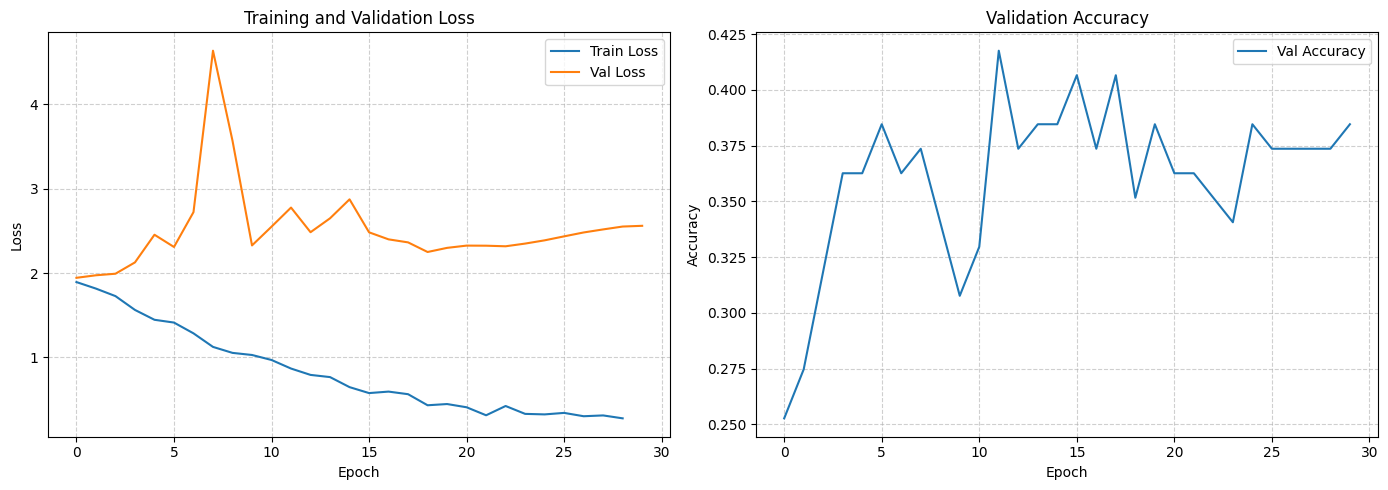

In [148]:
# Plot training metrics
plot_metrics(history)

In [149]:
# Save the trained model
torch.save(model.state_dict(), 'final_model.pth')

In [150]:
# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
model = to_device(model, device)

Evaluating test set: 100%|██████████| 1/1 [00:05<00:00,  5.92s/it]


Test Accuracy: 41.76%
              precision    recall  f1-score   support

       Angry       0.27      0.55      0.36        11
     Disgust       0.50      0.11      0.18         9
        Fear       0.33      0.14      0.20         7
   Happiness       0.73      0.55      0.63        20
     Neutral       0.20      0.36      0.26        11
         Sad       0.67      0.14      0.24        14
   Surprised       0.50      0.68      0.58        19

    accuracy                           0.42        91
   macro avg       0.46      0.36      0.35        91
weighted avg       0.50      0.42      0.40        91

Confusion Matrix:
[[ 6  0  0  2  1  0  2]
 [ 4  1  0  1  1  0  2]
 [ 2  0  1  0  2  0  2]
 [ 1  0  0 11  5  0  3]
 [ 2  1  0  0  4  1  3]
 [ 6  0  0  1  4  2  1]
 [ 1  0  2  0  3  0 13]]


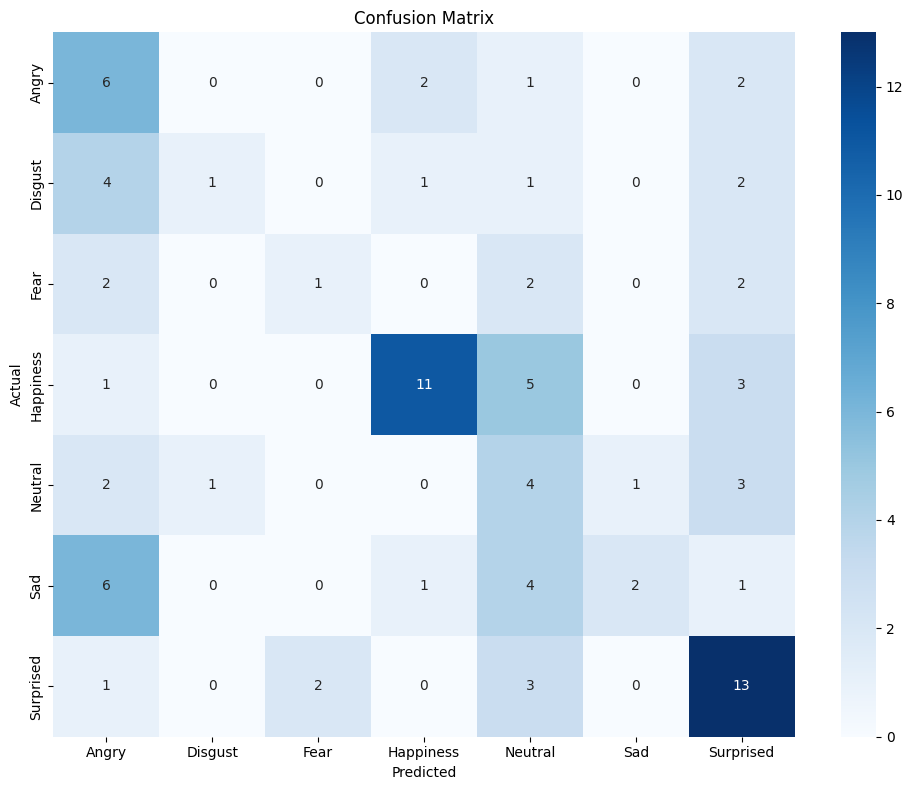

In [151]:
# Evaluate the model on the test dataset
test_acc, conf_matrix = evaluate_test_set(model, test_dl, classes)

In [152]:
# Function to visualize sample predictions
def visualize_predictions(model, test_dl, classes, num_samples=5):
    # Get a batch of images
    dataiter = iter(test_dl)
    images, labels = next(dataiter)

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Convert tensors to CPU
    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    # Function to denormalize images for display
    def denormalize(image, mean=stats[0], std=stats[1]):
        img_denorm = image.clone()
        for i in range(3):
            img_denorm[i] = img_denorm[i] * std[i] + mean[i]
        return torch.clamp(img_denorm, 0, 1)

    # Plot the images with predictions
    plt.figure(figsize=(15, 3))
    for i in range(min(num_samples, len(images))):
        # Denormalize image
        img = denormalize(images[i])
        # Convert to numpy for matplotlib
        img = img.permute(1, 2, 0).numpy()

        # Plot with colored text based on correctness
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')

        # Color text based on correct/incorrect prediction
        true_label = classes[labels[i]]
        pred_label = classes[preds[i]]
        color = 'green' if labels[i] == preds[i] else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()


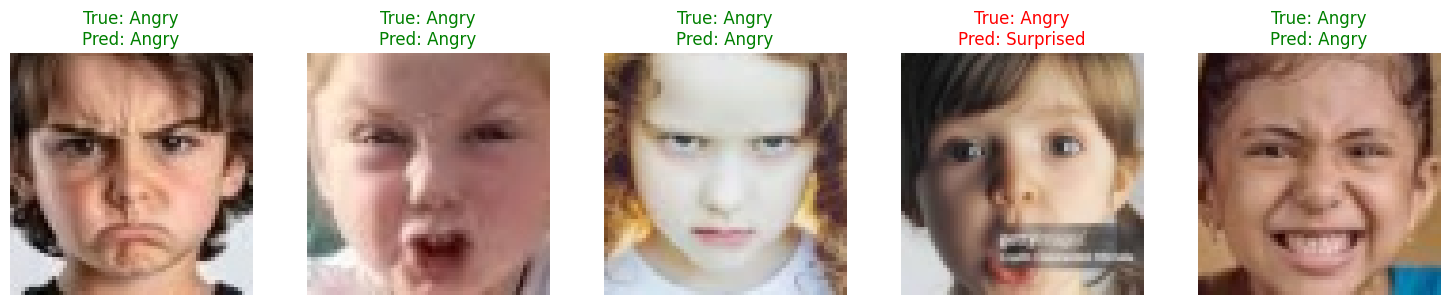

In [153]:
# Visualize some predictions
visualize_predictions(model, test_dl, classes, num_samples=5)

# Siemese Network

In [154]:
# Create model with proper number of classes
num_classes = len(classes)
model = ResNet50Model(num_classes, pretrained=True)
model = to_device(model, device)

c:\Users\anura\anaconda3\envs\NLP\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anura\anaconda3\envs\NLP\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [155]:
# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Percentage of trainable parameters: {trainable_params / total_params * 100:.2f}%")


Total parameters: 24,560,711
Trainable parameters: 15,492,615
Percentage of trainable parameters: 63.08%


In [156]:
# Get initial validation metrics
initial_result = evaluate(model, test_dl)
print("Initial validation metrics:", initial_result)

Initial validation metrics: {'val_loss': 1.9729677438735962, 'val_acc': 0.10989011079072952}


In [157]:
# Train the model
history = fit_one_cycle(
    epochs=30,  # Reduced from 100 to 50 for faster training
    max_lr=0.001,
    model=model,
    train_loader=train_dl,
    val_loader=test_dl,
    weight_decay=0.01,
    grad_clip=0.1,
    opt_func=torch.optim.Adam
)

Epoch 0: train_loss: 1.9765, val_loss: 1.8875, val_acc: 0.2967
Model saved at epoch 0 with val_acc: 0.2967


Epoch 1: train_loss: 1.8865, val_loss: 1.9248, val_acc: 0.2637


Epoch 2: train_loss: 1.8378, val_loss: 2.0624, val_acc: 0.2857


Epoch 3: train_loss: 1.7594, val_loss: 2.1102, val_acc: 0.3187
Model saved at epoch 3 with val_acc: 0.3187


Epoch 4: train_loss: 1.6388, val_loss: 2.3845, val_acc: 0.3077


Epoch 5: train_loss: 1.5383, val_loss: 2.8762, val_acc: 0.3407
Model saved at epoch 5 with val_acc: 0.3407


Epoch 6: train_loss: 1.2802, val_loss: 2.4276, val_acc: 0.3407


Epoch 7: train_loss: 1.1578, val_loss: 2.3617, val_acc: 0.3626
Model saved at epoch 7 with val_acc: 0.3626


Epoch 8: train_loss: 1.2130, val_loss: 3.0705, val_acc: 0.4176
Model saved at epoch 8 with val_acc: 0.4176


Epoch 9: train_loss: 1.1295, val_loss: 2.4330, val_acc: 0.4066


Epoch 10: train_loss: 0.9356, val_loss: 3.1295, val_acc: 0.3956


Epoch 11: train_loss: 0.9265, val_loss: 3.0695, val_acc: 0.3516


Epoch 12: train_loss: 0.7912, val_loss: 2.8424, val_acc: 0.3846


Epoch 13: train_loss: 0.7658, val_loss: 2.5639, val_acc: 0.4396
Model saved at epoch 13 with val_acc: 0.4396


Epoch 14: train_loss: 0.6717, val_loss: 2.5973, val_acc: 0.4176


Epoch 15: train_loss: 0.5914, val_loss: 2.4763, val_acc: 0.4615
Model saved at epoch 15 with val_acc: 0.4615


Epoch 16: train_loss: 0.6036, val_loss: 2.4247, val_acc: 0.4505


Epoch 17: train_loss: 0.4783, val_loss: 2.5162, val_acc: 0.4286


Epoch 18: train_loss: 0.4354, val_loss: 2.6538, val_acc: 0.3736


Epoch 19: train_loss: 0.3928, val_loss: 2.7524, val_acc: 0.3846


Epoch 20: train_loss: 0.4342, val_loss: 2.6071, val_acc: 0.4066


Epoch 21: train_loss: 0.3381, val_loss: 2.4588, val_acc: 0.4176


Epoch 22: train_loss: 0.2873, val_loss: 2.3990, val_acc: 0.3846


Epoch 23: train_loss: 0.4357, val_loss: 2.3676, val_acc: 0.3956


Epoch 24: train_loss: 0.3448, val_loss: 2.3681, val_acc: 0.4066


Epoch 25: train_loss: 0.2474, val_loss: 2.3878, val_acc: 0.4066


Epoch 26: train_loss: 0.2983, val_loss: 2.4287, val_acc: 0.4176


Epoch 27: train_loss: 0.3080, val_loss: 2.4675, val_acc: 0.4176


Epoch 28: train_loss: 0.3289, val_loss: 2.4941, val_acc: 0.4176


Epoch 29: train_loss: 0.2496, val_loss: 2.5223, val_acc: 0.4505


In [158]:
# Save the trained model
torch.save(model.state_dict(), 'final_model.pth')

In [159]:
# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
model = to_device(model, device)

Evaluating test set: 100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


Test Accuracy: 46.15%
              precision    recall  f1-score   support

       Angry       0.60      0.27      0.38        11
     Disgust       0.33      0.33      0.33         9
        Fear       0.00      0.00      0.00         7
   Happiness       0.53      0.45      0.49        20
     Neutral       0.40      0.55      0.46        11
         Sad       0.50      0.36      0.42        14
   Surprised       0.47      0.84      0.60        19

    accuracy                           0.46        91
   macro avg       0.40      0.40      0.38        91
weighted avg       0.45      0.46      0.43        91

Confusion Matrix:
[[ 3  1  0  3  2  0  2]
 [ 0  3  0  3  0  2  1]
 [ 0  0  0  0  3  1  3]
 [ 1  1  1  9  0  0  8]
 [ 0  1  0  0  6  1  3]
 [ 1  3  0  1  3  5  1]
 [ 0  0  0  1  1  1 16]]


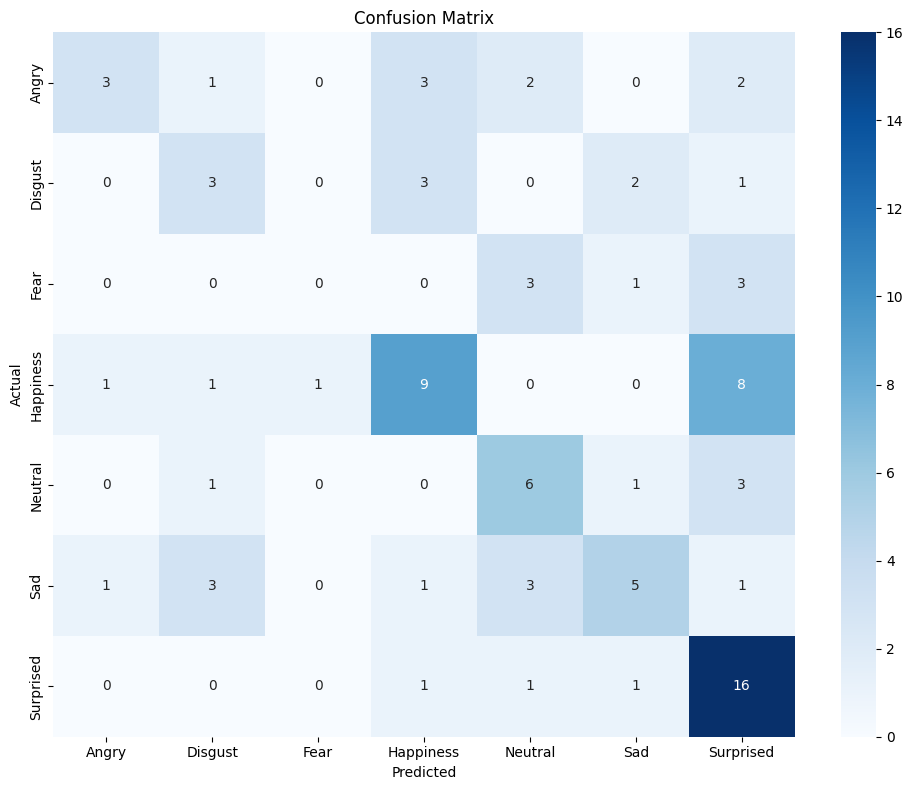

In [160]:
# Evaluate the model on the test dataset
test_acc, conf_matrix = evaluate_test_set(model, test_dl, classes)

In [163]:
# Function to visualize sample predictions
def visualize_predictions(model, test_dl, classes, num_samples=5):
    # Get a batch of images
    dataiter = iter(test_dl)
    images, labels = next(dataiter)

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Convert tensors to CPU
    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    # Function to denormalize images for display
    def denormalize(image, mean=stats[0], std=stats[1]):
        img_denorm = image.clone()
        for i in range(3):
            img_denorm[i] = img_denorm[i] * std[i] + mean[i]
        return torch.clamp(img_denorm, 0, 1)

    # Plot the images with predictions
    plt.figure(figsize=(15, 3))
    for i in range(min(num_samples, len(images))):
        # Denormalize image
        img = denormalize(images[i])
        # Convert to numpy for matplotlib
        img = img.permute(1, 2, 0).numpy()

        # Plot with colored text based on correctness
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')

        # Color text based on correct/incorrect prediction
        true_label = classes[labels[i]]
        pred_label = classes[preds[i]]
        color = 'green' if labels[i] == preds[i] else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()


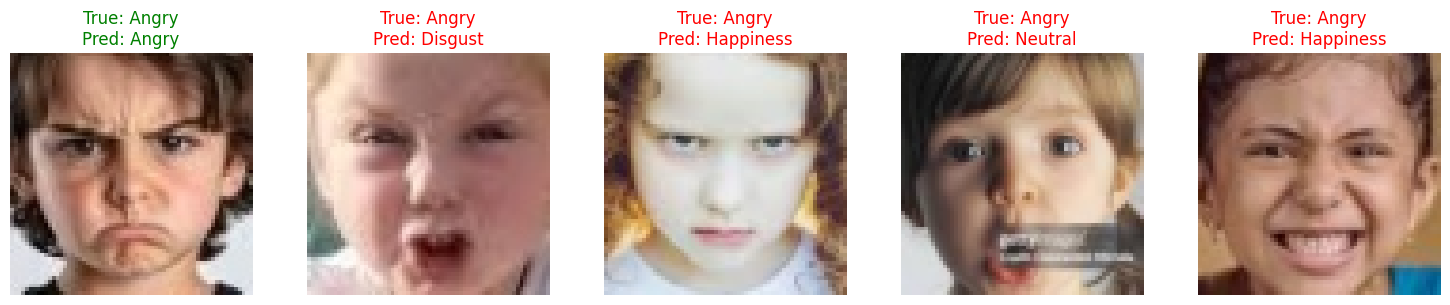

In [164]:
# Visualize some predictions
visualize_predictions(model, test_dl, classes, num_samples=5)